This is an attempt to recreate the parameter estimation [example](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/fig-html/appendix/fig-A-10.html) from James Rawlings book on [Reactor Design](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/) using Pyomo [parmest](https://pyomo.readthedocs.io/en/stable/contributed_packages/parmest/driver.html).

In [1]:
# Import libraries
from pyomo.environ import *
from pyomo.dae import *
import pyomo.contrib.parmest.parmest as parmest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This example has a series reaction $A \rightarrow B \rightarrow C$. The dataset consists of measures concentrations of A, B and C over time. The goal is to estimate the rate constants $k_1$ and $k_2$ for the two reactions.

In [2]:
data_df = pd.read_csv("ABC_data.csv")
data_df.head()

,t,ca,cb,cc
0,0.000,0.957,-0.031,-0.015
1,0.263,0.557,0.330,0.044
2,0.526,0.342,0.512,0.156
3,0.789,0.224,0.499,0.310
4,1.053,0.123,0.428,0.454


In [3]:
# Convert data to a list of dictionaries
data = [{'ca_meas': {k:v for (k, v) in zip(data_df.t, data_df.ca)},
    'cb_meas': {k:v for (k, v) in zip(data_df.t, data_df.cb)},
    'cc_meas': {k:v for (k, v) in zip(data_df.t, data_df.cc)} }]

In [4]:
#
# Define the model 
#
def ABC_model(data):
    
    ca_meas = data['ca_meas']
    cb_meas = data['cb_meas']
    cc_meas = data['cc_meas']
    
    meas_t = list(ca_meas.keys())
       
    ca0 = 1.0
    cb0 = 0.0
    cc0 = 0.0
        
    m = ConcreteModel()
    
    #m.k1 = Var(initialize = 0.5, bounds = (1e-4, 10))
    #m.k2 = Var(initialize = 3.0, bounds = (1e-4, 10))
    m.k1 = Var(initialize = 2.0)
    m.k2 = Var(initialize = 1.0)
    
    m.time = ContinuousSet(bounds = (0.0, 5.0), initialize = meas_t)
    #m.ca = Var(m.time, initialize = ca0, bounds = (0, ca0))
    #m.cb = Var(m.time, initialize = cb0, bounds = (0, ca0))
    #m.cc = Var(m.time, initialize = cc0, bounds = (0, ca0))
    m.ca = Var(m.time, initialize = ca0, bounds = (-1e-3, ca0+1e-3))
    m.cb = Var(m.time, initialize = cb0, bounds = (-1e-3, ca0+1e-3))
    m.cc = Var(m.time, initialize = cc0, bounds = (-1e-3, ca0+1e-3))
    
    m.dca = DerivativeVar(m.ca, wrt = m.time)
    m.dcb = DerivativeVar(m.cb, wrt = m.time)
    m.dcc = DerivativeVar(m.cc, wrt = m.time)
    
    def _dcarate(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            return m.dca[t] == -m.k1 * m.ca[t]
    m.dcarate = Constraint(m.time, rule = _dcarate)
    
    def _dcbrate(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            return m.dcb[t] == m.k1 * m.ca[t] - m.k2 * m.cb[t]
    m.dcbrate = Constraint(m.time, rule = _dcbrate)
    
    def _dccrate(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            return m.dcc[t] == m.k2 * m.cb[t]
    m.dccrate = Constraint(m.time, rule = _dccrate)
    
    def _initcon(m):
        yield m.ca[m.time.first()] == ca0
        yield m.cb[m.time.first()] == cb0
        yield m.cc[m.time.first()] == cc0
    m.initcon = ConstraintList(rule = _initcon)
    
    def ComputeFirstStageCost_rule(m):
        return 0
    m.FirstStageCost = Expression(rule=ComputeFirstStageCost_rule)

    def ComputeSecondStageCost_rule(m):
        return sum((m.ca[t] - ca_meas[t]) ** 2 + (m.cb[t] - cb_meas[t]) ** 2 
                   + (m.cc[t] - cc_meas[t]) ** 2 for t in meas_t) 
    m.SecondStageCost = Expression(rule=ComputeSecondStageCost_rule)

    
    def total_cost_rule(model):
        return model.FirstStageCost + model.SecondStageCost
    m.Total_Cost_Objective = Objective(rule=total_cost_rule, sense=minimize)
    
    disc = TransformationFactory('dae.collocation')
    disc.apply_to(m, nfe=20, ncp=2)
    
    return m

In [5]:
# parameters to be estimated
theta_names = ['k1', 'k2']

In [6]:
# First tried collocation method. Max iterations are exceeded
pest = parmest.Estimator(ABC_model, data, theta_names, tee = True)
obj, theta, cov = pest.theta_est(calc_cov=True)

Ipopt 3.12: bound_relax_factor=0
honor_original_bounds=no


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:      927
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      140

Total number of variables............................:      247
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      123
                     variables with only upper bounds:        0
Total number of equality constraints......

In [7]:
theta

{'k1': 2.014379762750679, 'k2': 0.9944520539909202}

In [8]:
cov

array([[-0.13200095,  0.02026254],
       [ 0.02026254, -0.0180948 ]])

In [9]:
# Get ca, cb, cc profiles with estimated parameters
ms = ABC_model(data[0])
ms.k1.fix(theta['k1'])
ms.k2.fix(theta['k2'])
solver = SolverFactory('ipopt')
solver.solve(ms, tee = True)

Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:      763
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       60

Total number of variables............................:      243
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      123
                     variables with only upper bounds:        0
Total number of equality constraints.................:      243
Total number of inequali

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 243, 'Number of variables': 243, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.03281998634338379}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

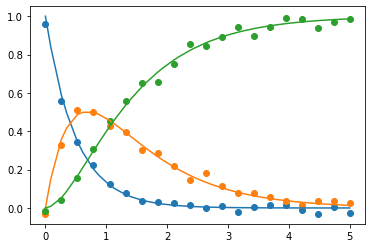

In [10]:
fig, ax = plt.subplots()
ax.plot(list(ms.time), [ms.ca[t]() for t in ms.time])
ax.plot(list(ms.time), [ms.cb[t]() for t in ms.time])
ax.plot(list(ms.time), [ms.cc[t]() for t in ms.time])
ax.scatter(data[0]['ca_meas'].keys(), data[0]['ca_meas'].values())
ax.scatter(data[0]['cb_meas'].keys(), data[0]['cb_meas'].values())
ax.scatter(data[0]['cc_meas'].keys(), data[0]['cc_meas'].values())